In [7]:
%load_ext autoreload
%autoreload 2

from owain_app.catalog import Catalog
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import jsonlines
from owain_app.create_tasks import get_all_rules, apply_rules
from owain_app.create_articulation_prompts import format_rule
import itertools
from itertools import combinations

catalog = Catalog()
responses = catalog.load_processed_icl_responses()

2023-11-30 22:35:35.117 | INFO     | owain_app.catalog:_load_jsonl:73 - Loading ProcessedICLPromptResponse instances from /Users/gabe/notes/Career/job_applications/Astra_Fellowship/owain_app/data/processed_icl_responses/processed_icl_responses.jsonl


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
data = pd.DataFrame([x.model_dump() for x in responses])
data['train_rule_names_str'] = data['train_rule_names'].apply(lambda x: ','.join(x))
# data['test_label'] = data['test_label'].astype(int)

val_predictions = data[data.split == 'val']
val_predictions['test_label'] = val_predictions['test_label'].astype(int)
val_predictions['prediction'] = val_predictions['prediction'].astype(int)
val_predictions_by_rule = val_predictions.groupby('train_rule_names_str')
val_accuracy_scores = val_predictions_by_rule.agg({'test_label': list, 'prediction': list}).apply(lambda x: accuracy_score(x.test_label, x.prediction), axis=1).sort_values(ascending=False)

val_accuracy_scores

/var/folders/b_/8s655bvn3bqfj_qkwfxmfdwm0000gn/T/ipykernel_40361/2647895070.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_predictions['test_label'] = val_predictions['test_label'].astype(int)
/var/folders/b_/8s655bvn3bqfj_qkwfxmfdwm0000gn/T/ipykernel_40361/2647895070.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_predictions['prediction'] = val_predictions['prediction'].astype(int)


train_rule_names_str
rule0,rule1    1.00
rule0,rule2    1.00
rule0,rule3    1.00
rule0,rule4    1.00
rule1,rule2    1.00
rule1,rule3    1.00
rule1,rule4    1.00
rule2,rule3    1.00
rule3,rule4    1.00
rule2,rule4    0.75
dtype: float64

In [9]:

test_predictions = data[data.split == 'test'].copy()

min_rules_per_answer = 1

def apply_rules_evaluation(s, rules):
    if all([r(s) for r in rules]):
        return 1
    # elif all([(not r(s)) for r in rules]):
    #     return 0
    else:
        return 0


all_rules = get_all_rules(string_length=5)
all_rule_combinations = list(
    itertools.chain.from_iterable(
        combinations(all_rules, r)
        for r in range(min_rules_per_answer, 3)
    )
)


rule_combination_columns = []
for rule_combination in all_rule_combinations:
    rule_combination_str = ' and '.join([format_rule(x.rule_name) for x in rule_combination])
    rule_combination_columns.append(rule_combination_str)
    test_predictions[rule_combination_str] = test_predictions["test_example"].apply(lambda x: apply_rules_evaluation(x, rule_combination))

def notna_accuracy_score(y_true, y_pred):
    return accuracy_score(y_true[y_true.notna() & y_pred.notna()], y_pred[y_true.notna() & y_pred.notna()])

rule_accuracies_all = []
for train_rule, df in test_predictions.groupby('train_rule_names_str'):
    rule_accuracies = df[rule_combination_columns].apply(lambda x: notna_accuracy_score(x, df['prediction'].astype(int)), axis=0)
    # print(.sort_values(ascending=False))
    # print()
    d = {"train_rule_names_str": train_rule}
    d.update(rule_accuracies) 
    rule_accuracies_all.append(
        d
    )

rule_accuracies_all = pd.DataFrame(rule_accuracies_all)

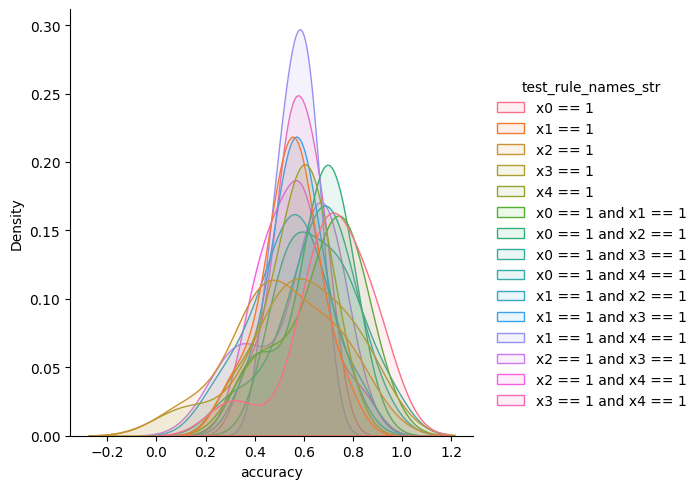

In [67]:
import seaborn as sns
df = rule_accuracies_all.melt(id_vars=['train_rule_names_str'], value_vars=rule_combination_columns, var_name='test_rule_names_str', value_name='accuracy')
overlaid = sns.displot(df, x="accuracy", hue="test_rule_names_str", kind="kde", fill=True, alpha=0.1)
overlaid.savefig('../figures/test_accuracy_distribution_by_rule.png')


In [11]:
import matplotlib.pyplot as plt
plt.clf()

overlaid.savefig("test_accuracy_distribution_by_rule.png")

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.05, 'Accuracy distribution by test rule')

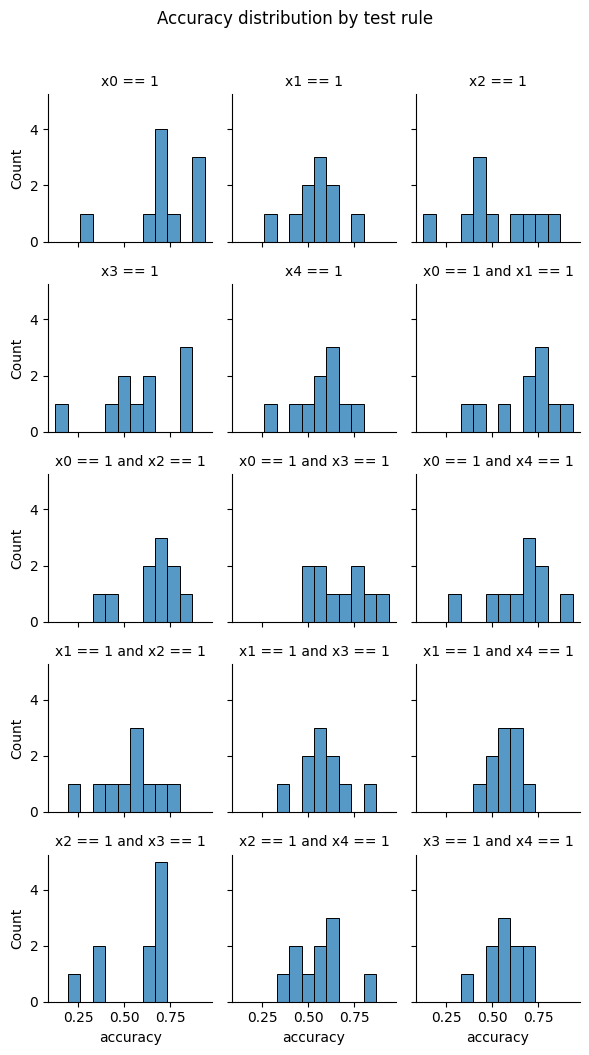

In [69]:
stacked = sns.displot(df, x="accuracy", col="test_rule_names_str", col_wrap=3, kind="hist", fill=True, height=2)
stacked.set_titles("{col_name}")
stacked.fig.suptitle("Accuracy distribution by test rule", y=1.05)
stacked.savefig('../figures/test_accuracy_distribution_by_rule_stacked.png')


In [13]:
from owain_app.catalog import Catalog

catalog = Catalog()

articulation_responses = catalog.load_processed_articulation_responses()

2023-11-30 22:35:51.141 | INFO     | owain_app.catalog:_load_jsonl:73 - Loading ProcessedArticulationPromptResponse instances from /Users/gabe/notes/Career/job_applications/Astra_Fellowship/owain_app/data/processed_articulation_responses/processed_articulation_responses.jsonl


In [14]:
import pandas as pd
articulation_response_data = pd.DataFrame([x.model_dump() for x in articulation_responses])

In [15]:
articulation_response_data['train_rule_names_str'] = articulation_response_data['train_rule_names'].apply(lambda x: ','.join(x))

In [34]:
def canonicalize_rule_string(rule_string):
    return ' and '.join(sorted(rule_string.split(' and ')))

In [36]:
rule_accuracies_all.columns = ['train_rule_names_str'] + [canonicalize_rule_string(x) for x in rule_accuracies_all.columns[1:]]

In [37]:
rule_accuracies_all

,train_rule_names_str,x0 == 1,x1 == 1,x2 == 1,x3 == 1,x4 == 1,x0 == 1 and x1 == 1,x0 == 1 and x2 == 1,x0 == 1 and x3 == 1,x0 == 1 and x4 == 1,x1 == 1 and x2 == 1,x1 == 1 and x3 == 1,x1 == 1 and x4 == 1,x2 == 1 and x3 == 1,x2 == 1 and x4 == 1,x3 == 1 and x4 == 1
0,"rule0,rule1",0.6875,0.3125,0.4375,0.5625,0.4375,0.8125,0.6875,0.8125,0.6875,0.5625,0.5625,0.5625,0.6875,0.5625,0.6875
1,"rule0,rule2",0.8750,0.6250,0.1250,0.5000,0.6250,0.8750,0.6250,0.7500,0.8750,0.3750,0.6250,0.6250,0.3750,0.3750,0.6250
2,"rule0,rule3",0.8750,0.6250,0.6250,0.1250,0.6250,0.7500,0.7500,0.5000,0.7500,0.6250,0.3750,0.6250,0.3750,0.6250,0.3750
3,"rule0,rule4",0.6875,0.5625,0.4375,0.8125,0.3125,0.6875,0.6875,0.9375,0.6875,0.5625,0.8125,0.5625,0.6875,0.4375,0.5625
4,"rule1,rule2",0.8750,0.5000,0.5000,0.6250,0.6250,0.7500,0.6250,0.7500,0.7500,0.5000,0.5000,0.5000,0.6250,0.6250,0.6250
5,"rule1,rule3",0.6875,0.5625,0.8125,0.4375,0.6875,0.6875,0.8125,0.5625,0.6875,0.6875,0.5625,0.6875,0.6875,0.8125,0.5625
6,"rule1,rule4",0.6875,0.4375,0.6875,0.8125,0.5625,0.5625,0.6875,0.6875,0.5625,0.5625,0.5625,0.4375,0.6875,0.5625,0.6875
7,"rule2,rule3",0.6250,0.5000,0.3750,0.6250,0.7500,0.3750,0.3750,0.5000,0.5000,0.2500,0.5000,0.5000,0.2500,0.5000,0.5000
8,"rule2,rule4",0.3125,0.5625,0.4375,0.8125,0.5625,0.4375,0.4375,0.5625,0.3125,0.4375,0.6875,0.5625,0.6875,0.4375,0.5625
9,"rule3,rule4",0.7500,0.7500,0.7500,0.5000,0.5000,0.7500,0.7500,0.6250,0.6250,0.7500,0.6250,0.6250,0.6250,0.6250,0.5000


In [41]:
predicted_rule

'x0 == 1'

In [51]:
accuracies_for_rule

,rule_string,accuracy
0,x0 == 1 and x2 == 1,0.6875
1,x0 == 1,0.6875
2,x1 == 1,0.3125
3,x0 == 1 and x1 == 1,0.8125


In [54]:
ranks = []
for train_rule_str, df in articulation_response_data.groupby('train_rule_names_str'):
    print(train_rule_str)
    for idx, row in df.iterrows():
        predicted_rule = [x for x in row.answer_options if (row.prediction_str + ':') in x][0][3:]
        accuracies_for_rule = rule_accuracies_all.loc[rule_accuracies_all.train_rule_names_str == train_rule_str, [canonicalize_rule_string(x[3:]) for x in row.answer_options]]
        accuracies_for_rule = accuracies_for_rule.loc[0,:]
        prediced_rule_accuracy_rank = accuracies_for_rule.sort_values(ascending=False).index.get_loc(canonicalize_rule_string(predicted_rule))
        print(accuracies_for_rule.sort_values(ascending=False))
        print(f"{predicted_rule} ({prediced_rule_accuracy_rank})")
        print()
        d = row.to_dict()
        d.update({
            'predicted_rule': predicted_rule,
            'predicted_rule_accuracy_rank': prediced_rule_accuracy_rank
        })
        ranks.append(d)

rule0,rule1
x0 == 1 and x1 == 1    0.8125
x0 == 1 and x2 == 1    0.6875
x0 == 1                0.6875
x1 == 1                0.3125
Name: 0, dtype: float64
x0 == 1 and x2 == 1 (1)

x0 == 1 and x1 == 1    0.8125
x0 == 1                0.6875
x1 == 1 and x3 == 1    0.5625
x2 == 1                0.4375
Name: 0, dtype: float64
x0 == 1 and x1 == 1 (0)

x0 == 1 and x1 == 1    0.8125
x0 == 1 and x2 == 1    0.6875
x0 == 1                0.6875
x4 == 1                0.4375
Name: 0, dtype: float64
x0 == 1 and x2 == 1 (1)

x0 == 1 and x1 == 1    0.8125
x0 == 1                0.6875
x1 == 1 and x2 == 1    0.5625
x2 == 1                0.4375
Name: 0, dtype: float64
x0 == 1 and x1 == 1 (0)

x0 == 1 and x1 == 1    0.8125
x0 == 1                0.6875
x2 == 1 and x3 == 1    0.6875
x4 == 1                0.4375
Name: 0, dtype: float64
x0 == 1 and x1 == 1 (0)

x0 == 1 and x1 == 1    0.8125
x2 == 1 and x3 == 1    0.6875
x0 == 1                0.6875
x2 == 1                0.4375
Name: 0, dtype: float64

KeyError: 0

In [56]:
ranks = pd.DataFrame(ranks)

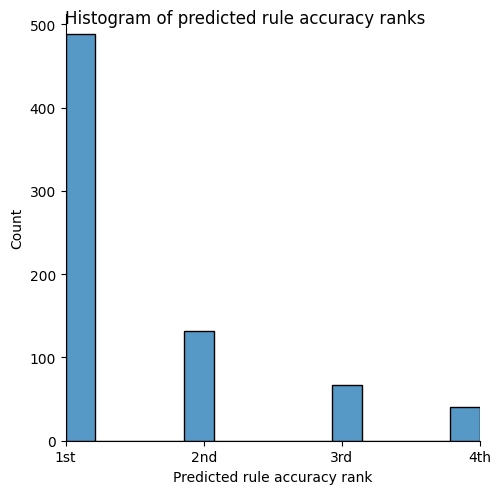

In [65]:
# histogram of predicted rule accuracy ranks

import seaborn as sns
g = sns.displot(ranks, x="predicted_rule_accuracy_rank", kind="hist", fill=True)
g.fig.suptitle("Histogram of predicted rule accuracy ranks")
g.set(xlabel="Predicted rule accuracy rank", ylabel="Count")
g.set(xlim=(0, 3))
g.savefig("predicted_rule_accuracy_ranks.png")
for ax in g.axes.flat:
    ax.set_xticks(range(4))
    ax.set_xticklabels(['1st', '2nd', '3rd', '4th'])

In [58]:
# join the data
# joined = articulation_response_data.merge(data, on=['train_rule_names_str'], suffixes=('_articulation', '_icl'))

In [26]:
articulation_response_data.dtypes

string_length                int64
notation_type               object
train_rule_names            object
train_examples              object
train_labels                object
answer_options              object
answer_option_rule_names    object
correct_answer_letters      object
prompt                      object
prediction_str              object
model                       object
train_rule_names_str        object
dtype: object

In [ ]:
def get_feature_columns(predictions_df):
    columns = [
        f"x{i+1}" for i in range(0, len(predictions_df["test_example"].values[0]))
    ]
    return columns


def normalize_predictions(data):
    responses = pd.json_normalize(data["response"])
    choices = pd.json_normalize(responses["choices"].apply(lambda x: x[0]))
    predictions = (
        choices["message.content"].map({"True": "1", "False": "0"}).rename("prediction")
    )
    return predictions


def normalize_prompt(data):
    return pd.json_normalize(data["prompt"])


def get_train_correlations(predictions_df):
    "A sanity check to see which features are correlated with the label in the training set"
    train_df = pd.DataFrame(predictions_df["train_examples"][0])
    train_df_ = pd.DataFrame(
        train_df[0].apply(lambda x: list(x)).values.tolist(),
        columns=["x1", "x2", "x3", "x4"],
    )
    train_df_["label"] = train_df[1].map({True: "1", False: "0"})
    train_correlations = train_df_.corr()["label"].round(2).sort_values(ascending=False)

    return train_correlations

def compute_val_accuracy(predictions_df):
    val_accuracy_n = len(predictions_df[predictions_df.split == "val"])

    val_accuracy_score = accuracy_score(
        predictions_df[predictions_df.split == "val"]["label"],
        predictions_df[predictions_df.split == "val"]["message.content"],
    )
    return val_accuracy_score, val_accuracy_n

def compute_accuracy_and_learned_rules():
    # read the data
    data_path = catalog.data_path / "model_responses_icl/n=4/rule0_and_rule1/all.jsonl"
    with jsonlines.open(data_path) as reader:
        data = [obj for obj in reader]

    # convert to dataframe
    data = pd.DataFrame(data, columns=["input", "response", "prompt"])

    predictions = normalize_predictions(data)
    prompt = normalize_prompt(data)

    predictions_df = pd.concat([prompt, predictions], axis=1)
    predictions_df["label"] = predictions_df["label"].map(
        {True: "1", False: "0", None: np.nan}
    )
    
    train_correlations = get_train_correlations(predictions_df)

    features = pd.DataFrame(
        predictions_df["test_example"].apply(lambda x: list(x)).values.tolist(),
        columns=columns,
    )

    columns = get_feature_columns(predictions_df)

    predictions_df_cat = pd.concat([features, predictions_df["message.content"]], axis=1)

    # get correlations between features and predictions
    feature_correlations = predictions_df_cat.corr()["prediction"].round(2).sort_values(ascending=False)

    
    val_accuracy_score, val_accuracy_n = compute_val_accuracy(predictions_df)

    return {
        "val_accuracy_score": val_accuracy_score,
        "val_accuracy_n": val_accuracy_n,
        "feature_correlations": feature_correlations,
        "train_correlations": train_correlations,
    }